In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from random import seed
from scipy import stats
import seaborn as sns
import pingouin as pg
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
from statsmodels.regression import linear_model
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
%matplotlib inline

seed(888)
pd.set_option('display.max_columns', None)

# 1 Load validation set

In [134]:
# load data from pickle and convert to dataframe
brain_test = pd.read_pickle("brain_test_validate.pkl")
main_test = pd.read_pickle("main_test_validate.pkl")
brain_train = pd.read_pickle("2_brain_train.pkl")
brain_test = pd.DataFrame(brain_test)
main_test = pd.DataFrame(main_test)
brain_train = pd.DataFrame(brain_train)

# 2 Preprocessing of validation set

## 2.1 Physical activity preprocessing

People excluded due to wear time < 8000 minutes: 1147
People with data quality good wear time: Yes    8411
No        0
Name: data_quality_good_wear_time_f90015_0_0, dtype: int64
People with data quality good calibration: Yes    8411
No        0
Name: data_quality_good_calibration_f90016_0_0, dtype: int64


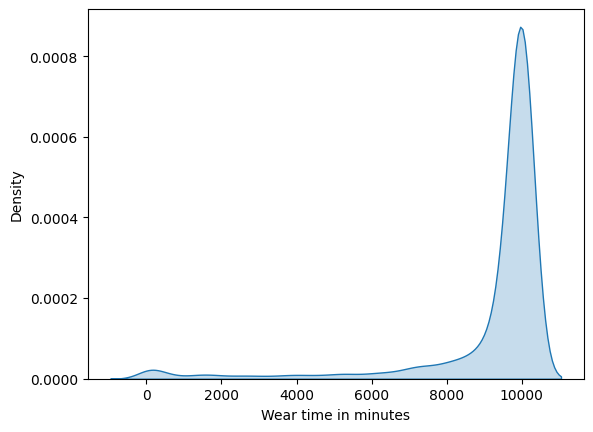

In [135]:
# get weartime duration in minutes (it's in days at default)
main_test["Wear time in minutes"] = main_test.iloc[:,16686]*1440
sns.kdeplot(data = main_test, x= 'Wear time in minutes', fill=True)

# exclude people with insufficient weartime weartime < 8000 minutes
wear_time_test = main_test[main_test["Wear time in minutes"]<8000].index
print("People excluded due to wear time < 8000 minutes:", len(wear_time_test))
brain_test = brain_test.drop(wear_time_test)
main_test = main_test.drop(wear_time_test)

# check wear time and data quality
print("People with data quality good wear time:", main_test.iloc[:,16650].value_counts())
print("People with data quality good calibration:", main_test.iloc[:,16651].value_counts())

In [136]:
# distributions are cumulative -> substract ditributions from each other
# determine fraction of weartime spent doing light PA (between 30 and 125 milligravites)
light_PA = np.asarray(main_test.iloc[:,16763]-main_test.iloc[:,16748])
# get it in minutes / week
light_PA = light_PA * main_test["Wear time in minutes"]
main_test["Light PA"] = light_PA

# determine fraction of weartime spent doing moderate PA (between 125 and 400 milligravites)
moderate_PA = np.asarray(main_test.iloc[:,16774]-main_test.iloc[:,16763])
moderate_PA = moderate_PA * main_test["Wear time in minutes"]
main_test["Moderate PA"] = moderate_PA

# determine fraction of weartime spent doing vigorous PA (above 400 milligravites)
vigorous_PA = np.asarray(1-main_test.iloc[:,16774])
vigorous_PA = vigorous_PA * main_test["Wear time in minutes"]
main_test["Vigorous PA"] = vigorous_PA

# fraction of weartime for above 30 mg -> total summed light, moderate, and vigorous PA
total_PA = np.asarray(1-main_test.iloc[:,16748])
total_PA = total_PA * main_test["Wear time in minutes"]
main_test["Total PA"] = total_PA

# moderate + 2* vigorous PA -> weighten greater than moderate activity
main_test["MVPA"] = main_test["Moderate PA"] + main_test["Vigorous PA"]*2

## 2.2 Exclusions

In [137]:
main_test["Excluded"] = 0

# exclude people with disorders of the nervous system
nervous_test = main_test[main_test["diagnoses_icd10_f41270_0_0"].str.contains("G")==True].index
main_test.loc[nervous_test,"Excluded"] = 1
print("People excluded due to disorders of the nervous system (G):", len(nervous_test))

# exclude people with malicious neoplasm in the brain
neoplasm_test = main_test[main_test["diagnoses_icd10_f41270_0_0"].str.contains("C71")==True].index
main_test.loc[neoplasm_test,"Excluded"] = 1
print("People excluded due to malicious neoplasms in the brain (C71):",len(neoplasm_test))

# exclude people with circulatory disease 
circulatory_test = main_test[main_test["diagnoses_icd10_f41270_0_0"].str.contains("I")==True].index
main_test.loc[circulatory_test,"Excluded"] = 1
print("People excluded due to circulatory disease (I):",len(circulatory_test))

print("Total number of exclusions in test set:", len(nervous_test)+len(neoplasm_test)+len(circulatory_test))

brain_test = brain_test[main_test["Excluded"]==0]
main_test = main_test[main_test["Excluded"]==0]

before_test = main_test.shape[0]
good_test = main_test.iloc[:,10065].isnull()
brain_test = brain_test[good_test]
main_test = main_test[good_test]
after_test = main_test.shape[0]
print("People excluded due to poor quality brain scan:", before_test - after_test)

brain_test = pd.DataFrame(brain_test)
main_test = pd.DataFrame(main_test)

People excluded due to disorders of the nervous system (G): 256
People excluded due to malicious neoplasms in the brain (C71): 4
People excluded due to circulatory disease (I): 605
Total number of exclusions in test set: 865
People excluded due to poor quality brain scan: 14


## 2.2 BrainAge prediction for A2009 and All variables

In [138]:
nan_all_test = brain_test[brain_test.iloc[:,1:2544:2].isnull().any(axis=1)].index
nan_all_train = brain_train[brain_train.iloc[:,1:2544:2].isnull().any(axis=1)].index
main_test = main_test.drop(nan_all_test)
brain_test = brain_test.drop(nan_all_test)
brain_train = brain_train.drop(nan_all_train)

print("Number of people with missing brain values in train set:", len(nan_all_train))
print("Number of people with missing brain values in test set:", len(nan_all_test))

Number of people with missing brain values in train set: 56
Number of people with missing brain values in test set: 23


### 2.2.1 A2009

In [139]:
X_train = brain_train.iloc[:,1657:2544:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,1657:2544:2]
Y_test = brain_test.iloc[:,-1]

In [140]:
# set of alphas to try (=penalization)
alpha_parameters = np.power(10,np.linspace(start=-3, stop=5, num=100))

# standardize x-data
X_train_std = stats.zscore(X_train)
X_test_std = stats.zscore(X_test)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))

The MAE for cross-validation (Ridge): 4.203354668044857


The MAE for testing set using Ridge: 4.2098190859052105
Index(['volume_of_scentral_right_hemisphere_f27743_2_0',
       'area_of_latfispost_right_hemisphere_f27591_2_0',
       'area_of_scalcarine_left_hemisphere_f27372_2_0',
       'volume_of_gscingulant_right_hemisphere_f27704_2_0',
       'area_of_gfrontsup_left_hemisphere_f27344_2_0',
       'volume_of_sparietooccipital_right_hemisphere_f27763_2_0',
       'volume_of_scentral_left_hemisphere_f27521_2_0',
       'volume_of_latfispost_right_hemisphere_f27739_2_0',
       'area_of_scalcarine_right_hemisphere_f27594_2_0',
       'volume_of_scalcarine_right_hemisphere_f27742_2_0'],
      dtype='object')
[ 1.53888587 -1.55304992 -1.57459018 -1.57787721 -1.66434479  1.69489945
  1.88236986  2.24963723 -2.41630511  2.4641046 ]


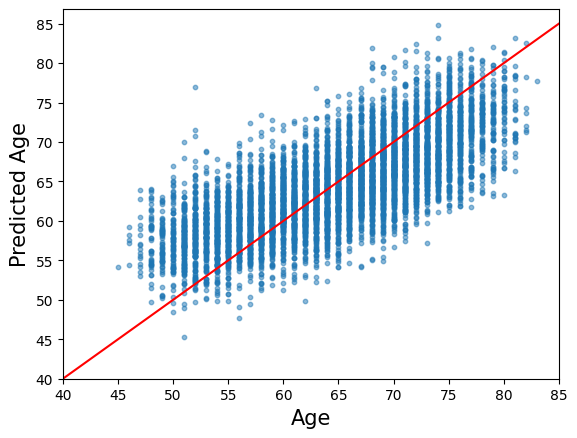

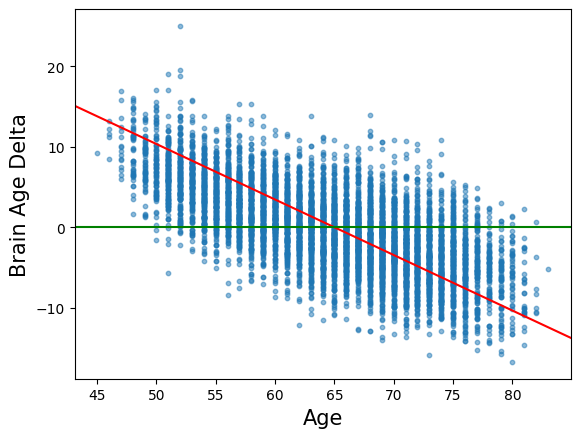

In [141]:
#model_Lasso = LassoCV(alphas = alpha_parameters, max_iter=100000)
model_Ridge = RidgeCV(alphas = alpha_parameters)
#model_SVR = SVR(kernel = 'rbf')

# train model on training data
#model_Lasso.fit(X_train_std,Y_train)
model_Ridge.fit(X_train_std,Y_train)
#model_SVR.fit(X_train_std,Y_train)

# get predicted values for test set
#y_pred_Lasso = model_Lasso.predict(X_test_std)
y_pred_Ridge = model_Ridge.predict(X_test_std)
#y_pred_SVR = model_SVR.predict(X_test_std)

# calculate brain age gap
#brain_age_delta_Lasso = y_pred_Lasso-Y_test
brain_age_delta_Ridge = y_pred_Ridge-Y_test
#brain_age_delta_SVR = y_pred_SVR-Y_test

# get mean absolute error (MAE)
#print("The MAE for testing set using Lasso:", mean_absolute_error(Y_test,y_pred_Lasso))
print("The MAE for testing set using Ridge:", mean_absolute_error(Y_test,y_pred_Ridge))
#print("The MAE for testing set using SVR:", mean_absolute_error(Y_test,y_pred_SVR))

coeff = np.asarray(model_Ridge.coef_)
coeffabs = np.asarray(abs(model_Ridge.coef_))
top_10_coefficients = np.argsort(coeffabs)[-10:]
print(X_train_std.iloc[:,top_10_coefficients].columns)
print(coeff[top_10_coefficients])

#plot figure with x: actual age Y: predicted age, and a line with slope 1 for reference
plt.figure()
plt.scatter(Y_test, y_pred_Ridge, alpha=0.5, s=10)
plt.axline((60,60), slope=1, color='r')
plt.xticks(range(40,90,5))
plt.yticks(range(40,90,5))
plt.ylabel('Predicted Age', fontsize = 15)
plt.xlabel('Age', fontsize = 15)
plt.show()

plt.figure()
plt.scatter(Y_test,brain_age_delta_Ridge, alpha=0.5, s=10)
plt.axline((65,0), slope=-0.69, color="r")
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()


Coefficient and Intercept: 0.5372001780843628 29.954171238012357
The MAE for testing set corrected: 5.6847452799786415


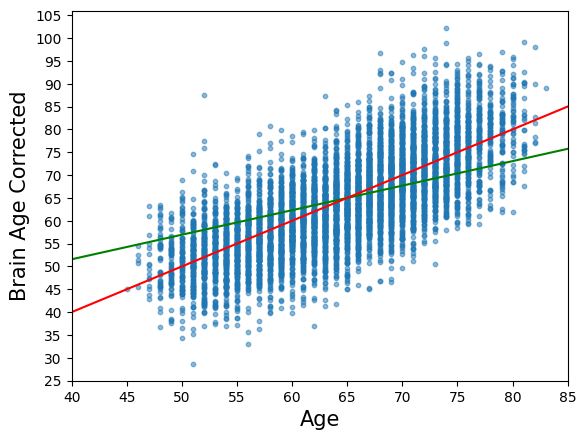

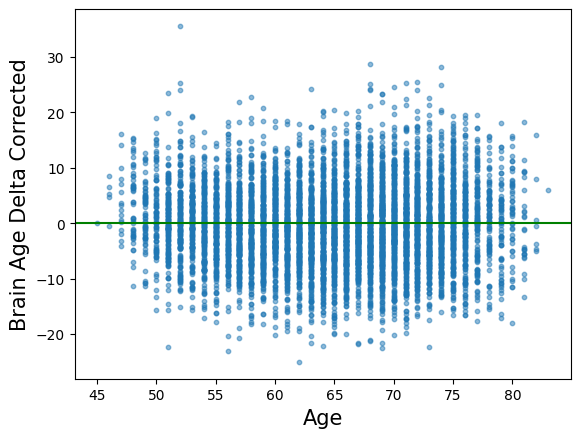

In [142]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_1 = vfunc(y_pred_Ridge)
corr_brainage_delta_1 = corr_brainage_1-Y_test

print("The MAE for testing set corrected:", mean_absolute_error(Y_test,corr_brainage_1))

plt.figure()
plt.scatter(Y_test, corr_brainage_1, alpha=0.5, s=10)
plt.axline((65,65), slope=coef, color="g")
plt.ylabel("Brain Age Corrected", fontsize = 15)
plt.axline((60,60), slope=1, color='r')
plt.xlabel("Age", fontsize = 15)
plt.xticks(range(40,90,5))
plt.yticks(range(25,110,5))
plt.show()

plt.figure()
plt.scatter(Y_test, corr_brainage_delta_1, alpha=0.5, s=10)
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

### 2.2.2 All Variables

In [143]:
X_train = brain_train.iloc[:,1:2544:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,1:2544:2]
Y_test = brain_test.iloc[:,-1]

# standardize x-data
X_train_std = stats.zscore(X_train)
X_test_std = stats.zscore(X_test)
#print(X_train_std)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))

#model_Lasso = LassoCV(alphas = alpha_parameters, max_iter=100000, tol=1e-2)
model_Ridge = RidgeCV(alphas = alpha_parameters)
#model_SVR = SVR(kernel = 'rbf')

# train model on training data
#model_Lasso.fit(X_train_std,Y_train)
model_Ridge.fit(X_train_std,Y_train)
#model_SVR.fit(X_train_std,Y_train)


coeff = np.asarray(model_Ridge.coef_)
coeffabs = np.asarray(abs(model_Ridge.coef_))
top_10_coefficients = np.argsort(coeffabs)[-10:]
print(X_train_std.iloc[:,top_10_coefficients].columns)
print(coeff[top_10_coefficients])

# get predicted values for test set
#y_pred_Lasso = model_Lasso.predict(X_test_std)
y_pred_Ridge = model_Ridge.predict(X_test_std)
#y_pred_SVR = model_SVR.predict(X_test_std)

# calculate brain age gap
#brain_age_delta_Lasso = y_pred_Lasso-Y_test
brain_age_delta_Ridge = y_pred_Ridge-Y_test
#brain_age_delta_SVR = y_pred_SVR-Y_test

# # get mean absolute error (MAE)
# print("The MAE for testing set using Lasso:", mean_absolute_error(Y_test,y_pred_Lasso))
# print("The MAE for testing set using Ridge:", mean_absolute_error(Y_test,y_pred_Ridge))
# print("The MAE for testing set using SVR:", mean_absolute_error(Y_test,y_pred_SVR))

# print("The Spearman r for Ridge vs Lasso:", stats.spearmanr(brain_age_delta_Ridge, brain_age_delta_Lasso))
# print("The Spearman r for Ridge vs SVR:", stats.spearmanr(brain_age_delta_Ridge, brain_age_delta_SVR))
# print("The Spearman r for SVR vs Lasso:", stats.spearmanr(brain_age_delta_SVR, brain_age_delta_Lasso))

# plt.figure()
# plt.scatter(Y_test, y_pred_Ridge, alpha=0.5, s=10)
# plt.axline((60,60), slope=1, color='r')
# plt.xticks(range(40,90,5))
# plt.yticks(range(40,90,5))
# plt.ylabel('Predicted Age', fontsize = 15)
# plt.xlabel('Age', fontsize = 15)
# plt.show()

# plt.figure()
# plt.scatter(Y_test,brain_age_delta_Ridge, alpha=0.5, s=10)
# plt.axline((65,0), slope=-0.69, color="r")
# plt.axline((60,0),slope=0, color = "g")
# plt.ylabel("Brain Age Delta", fontsize = 15)
# plt.xlabel("Age", fontsize = 15)
# plt.show()

The MAE for cross-validation (Ridge): 3.1003269293274576
Index(['greywhite_contrast_in_precuneus_right_hemisphere_f27048_2_0',
       'volume_of_subcortgray_whole_brain_f26517_2_0',
       'volume_of_midbrain_whole_brain_f26719_2_0',
       'volume_of_vlp_left_hemisphere_f26686_2_0',
       'greywhite_contrast_in_inferiorparietal_right_hemisphere_f27031_2_0',
       'greywhite_contrast_in_precuneus_left_hemisphere_f27013_2_0',
       'volume_of_ventraldc_right_hemisphere_f26596_2_0',
       'volume_of_wholebrainstem_whole_brain_f26720_2_0',
       'volume_of_brainstem_whole_brain_f26526_2_0',
       'volume_of_pons_whole_brain_f26717_2_0'],
      dtype='object')
[-0.76938267  0.86366409  0.88394109 -0.886367    0.90940705 -0.93141687
 -1.01363682  1.1090283  -1.16679698  1.46889789]


In [144]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_4 = vfunc(y_pred_Ridge)
corr_brainage_delta_4 = corr_brainage_4-Y_test

print("The MAE for testing set corrected:", mean_absolute_error(Y_test,corr_brainage_4))

# plt.figure()
# plt.scatter(Y_test, corr_brainage_4, alpha=0.5, s=10)
# plt.ylabel("Brain Age Corrected", fontsize = 15)
# plt.axline((60,60), slope=1, color='r')
# plt.xlabel("Age", fontsize = 15)
# plt.xticks(range(40,90,5))
# plt.yticks(range(25,110,5))
# plt.show()

# plt.figure()
# plt.scatter(Y_test, corr_brainage_delta_4, alpha=0.5, s=10)
# plt.axline((60,0),slope=0, color = "g")
# plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
# plt.xlabel("Age", fontsize = 15)
# plt.show()

Coefficient and Intercept: 0.7473028420808355 16.309587401170532
The MAE for testing set corrected: 3.6147891553628995


### 2.2.3 Add BrainAge Deltas to Dataframe

In [145]:
main_test["BADA2009"] = corr_brainage_delta_1
main_test["BADAll"] = corr_brainage_delta_4

## 2.3 Variable Selection

In [146]:
# same for full dataset without exclusions
main_test_crop = []
main_test_crop = pd.DataFrame(main_test_crop)

main_test_crop["Age"] = main_test["Age"]
main_test_crop["Gender"] = main_test.iloc[:,22]
main_test_crop["TPA"] = main_test["Total PA"]
main_test_crop["VPA"] = main_test["Vigorous PA"]
main_test_crop["MPA"] = main_test["Moderate PA"]
main_test_crop["MVPA"] = main_test["MVPA"]
main_test_crop["LPA"] = main_test["Light PA"]
main_test_crop["BMI"] = main_test.iloc[:,11580]
main_test_crop["ECGW"] = main_test.iloc[:, 5773]
main_test_crop["ECGHR"] = main_test.iloc[:, 5775]
main_test_crop["SRLPA"] = main_test.iloc[:,9989]
main_test_crop["SRMPA"] = main_test.iloc[:,9990]
main_test_crop["SRVPA"] = main_test.iloc[:,9991]
main_test_crop["FI"] = main_test.iloc[:,9052]
main_test_crop["HGL"] = main_test.iloc[:,64]
main_test_crop["HGR"] = main_test.iloc[:,68]
main_test_crop["IS"] = main_test['uk_biobank_assessment_centre_f54_2_0']
main_test_crop["Smoking"] = main_test.iloc[:,650]
main_test_crop["SES"] = main_test.iloc[:,456]
main_test_crop["HR"] = main_test.iloc[:,10079]
main_test_crop["JPA"] = main_test.iloc[:,507]
main_test_crop["DBP"] = main_test.iloc[:,1551]
main_test_crop["SBP"] = main_test.iloc[:,1559]
main_test_crop["WS"] = main_test.iloc[:,542]
main_test_crop["BADA2009"] = main_test["BADA2009"]
main_test_crop["BADAll"] = main_test["BADAll"]

main_test = main_test_crop

## 2.4 Recoding

In [147]:
# 1 = Cheadle;  2 = Reading;  3 = Newcastle;  4 = Bristol
main_test['IS'] = main_test['IS'].map({'11025': 1, '11026': 2,'11027': 3, '11028': 4})
main_test["Smoking"] = main_test["Smoking"].map({"No":0, "Only occasionally":1, "Yes, on most or all days":2})
main_test["Gender"] = main_test["Gender"].map({"Female":0, "Male":1})
main_test["Gender"] = main_test["Gender"].astype("int")
main_test["JPA"] = main_test["JPA"].map({"Never/rarely":0, "Sometimes":1, "Usually":2,"Always":3})
main_test["WS"] = main_test["WS"].map({"Slow pace":0, "Steady average pace":1, "Brisk pace":2})


main_test = main_test.rename(columns={"BADA2009": "BA"})
main_test = pd.DataFrame(main_test)


# 3 Basic distributions of validation set

## 3.1 Data and Descriptives

In [148]:
main_test.head()

,Age,Gender,TPA,VPA,MPA,MVPA,LPA,BMI,ECGW,ECGHR,SRLPA,SRMPA,SRVPA,FI,HGL,HGR,IS,Smoking,SES,HR,JPA,DBP,SBP,WS,BA,BADAll
24945,65.0,1,1474.0416,18.0864,198.9504,235.1232,1257.0048,28.9,NaN,NaN,412.5,80.0,0.0,7.0,49.0,40.0,1,0.0,-2.27794,NaN,0.0,81.0,121.0,2.0,11.234269,2.758950
34655,61.0,1,2388.9600,50.4000,463.6800,564.4800,1874.8800,23.9,NaN,NaN,198.0,400.0,240.0,6.0,29.0,29.0,1,0.0,-3.79876,55.0,0.0,88.0,156.0,2.0,0.534652,-0.769842
21099,55.0,0,2246.7456,8.5104,272.3328,289.3536,1965.9024,44.5,NaN,NaN,1386.0,240.0,0.0,6.0,26.0,26.0,1,0.0,-1.96244,NaN,0.0,115.0,185.0,1.0,-2.213423,0.987316
23431,67.0,1,1854.7200,40.3200,413.2800,493.9200,1401.1200,25.1,NaN,NaN,396.0,320.0,960.0,6.0,36.0,19.0,1,0.0,-1.88219,54.0,NaN,85.0,148.0,2.0,1.807830,4.157389
16532,53.0,1,2469.6000,20.1600,594.7200,635.0400,1854.7200,25.1,NaN,NaN,1039.5,480.0,1120.0,NaN,37.0,42.0,1,0.0,-4.49378,80.0,0.0,80.0,135.0,2.0,6.057764,-1.402666


In [149]:
female = main_test[main_test["Gender"] == 0]
male = main_test[main_test["Gender"]== 1]

print(female.shape)
print(male.shape)

print("Age")
mean = female["Age"].mean()
print("Female", mean)
std = female["Age"].std()
print("Female",std)
mean = male["Age"].mean()
print("Male",mean)
std = male["Age"].std()
print("Male",std)

print("LPA")
mean = female["LPA"].mean()
print("Female", mean)
std = female["LPA"].std()
print("Female",std)
mean = male["LPA"].mean()
print("Male",mean)
std = male["LPA"].std()
print("Male",std)

print("MPA")
mean = female["MPA"].mean()
print("Female", mean)
std = female["MPA"].std()
print("Female",std)
mean = male["MPA"].mean()
print("Male",mean)
std = male["MPA"].std()
print("Male",std)

print("VPA")
mean = female["VPA"].mean()
print("Female", mean)
std = female["VPA"].std()
print("Female",std)
mean = male["VPA"].mean()
print("Male",mean)
std = male["VPA"].std()
print("Male",std)

print("BMI")
mean = female["BMI"].mean()
print("Female", mean)
std = female["BMI"].std()
print("Female",std)
mean = male["BMI"].mean()
print("Male",mean)
std = male["BMI"].std()
print("Male",std)

# add all variables here

(4127, 26)
(3382, 26)
Age
Female 63.84637751393264
Female 7.586096604489041
Male 65.50177409816676
Male 7.824598313161009
LPA
Female 2071.04368422583
Female 404.4925350212614
Male 1906.929179893554
Male 410.40325284438757
MPA
Female 502.15591373879334
Female 225.3716719530624
Male 471.9675108219989
Male 218.42420616081864
VPA
Female 31.57773801793073
Female 41.32095414687484
Male 37.880813719692526
Male 47.10096326207537
BMI
Female 25.87552773686794
Female 4.533537901148013
Male 26.945712578428445
Male 3.807218816303094


## 3.2 Age and BrainAge

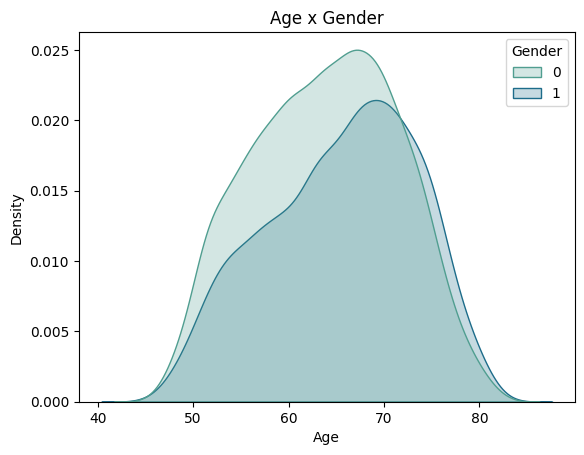

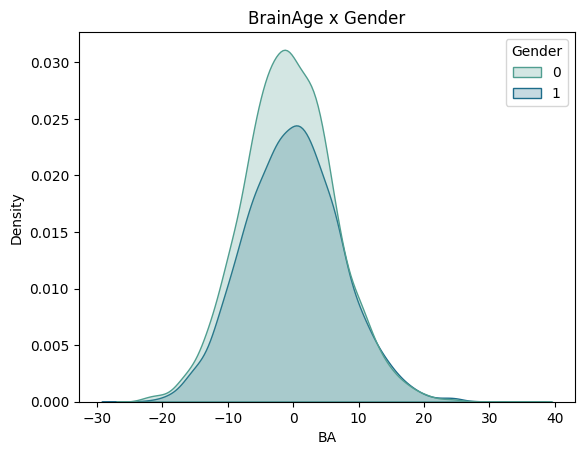

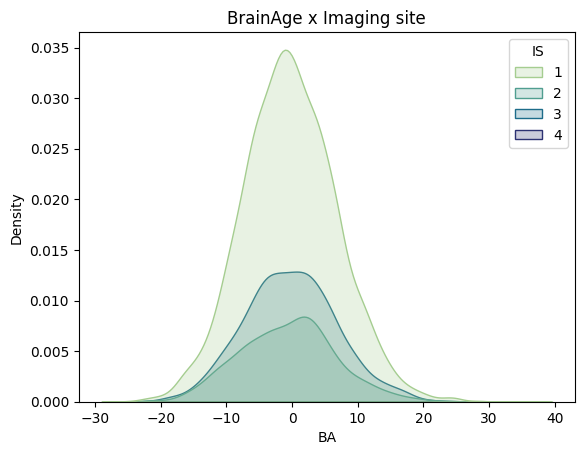

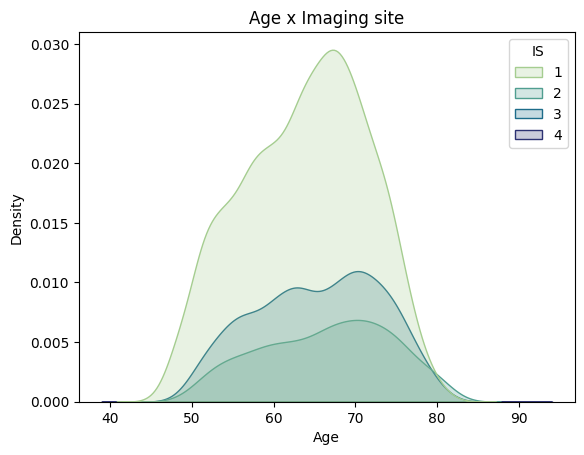

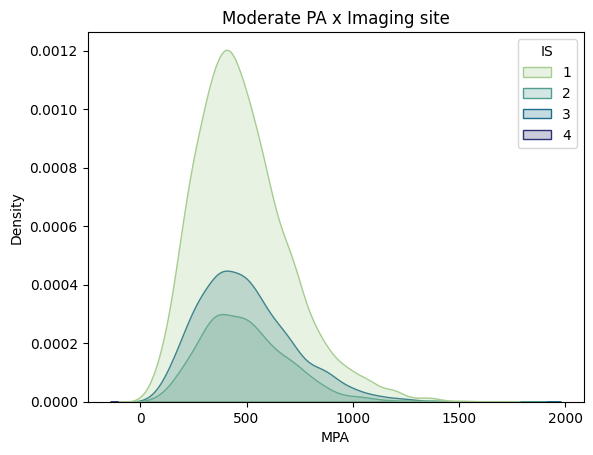

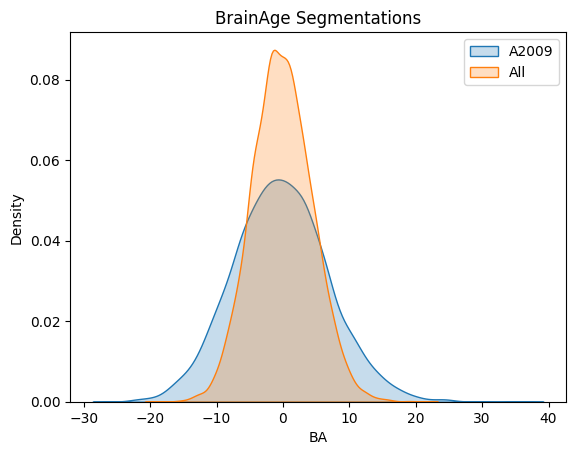

In [150]:
plt.figure()
sns.kdeplot(data = main_test, x= 'Age', hue = 'Gender', fill=True, palette = "crest")
plt.title("Age x Gender")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'BA', hue = 'Gender', fill=True, palette = "crest")
plt.title("BrainAge x Gender")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'BA', hue = 'IS', fill=True, palette = "crest")
plt.title("BrainAge x Imaging site")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'Age', hue = 'IS', fill=True, palette = "crest")
plt.title("Age x Imaging site")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'MPA', hue = 'IS', fill=True, palette = "crest")
plt.title("Moderate PA x Imaging site")
plt.show()


plt.figure()
sns.kdeplot(data = main_test, x= 'BA', fill=True, label="A2009")
sns.kdeplot(data = main_test, x= 'BADAll', fill=True, label="All")
plt.title("BrainAge Segmentations")
plt.legend()
plt.show()

## 3.3 Physical activity

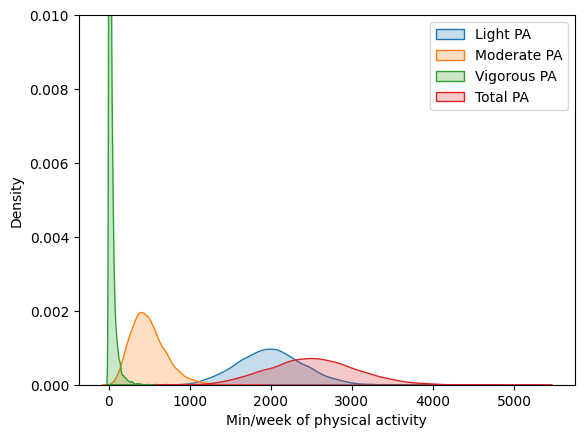

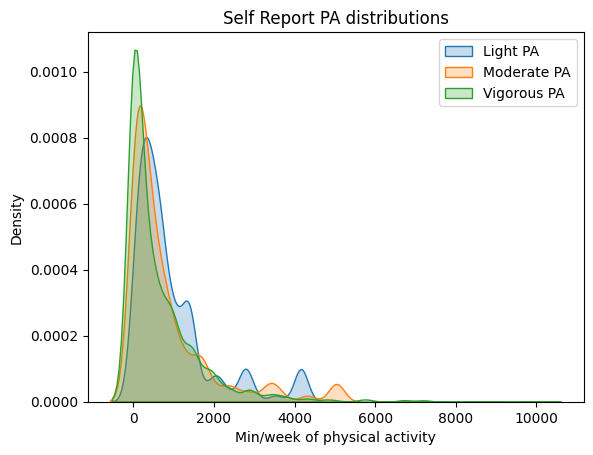

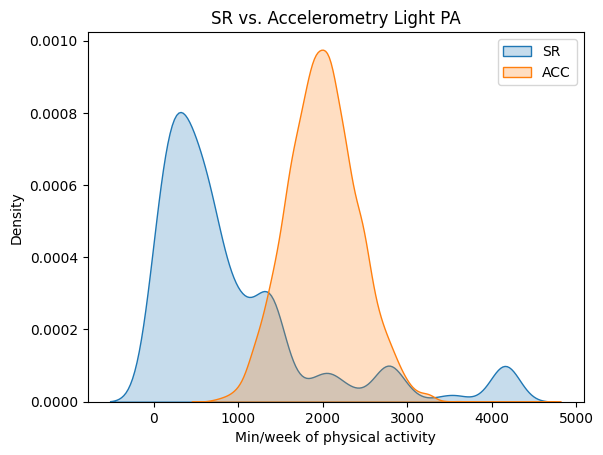

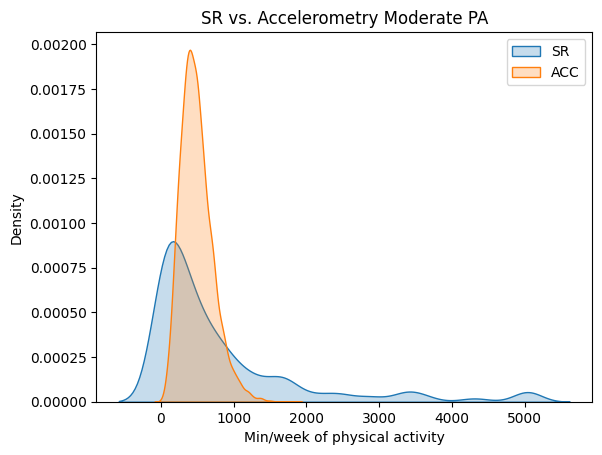

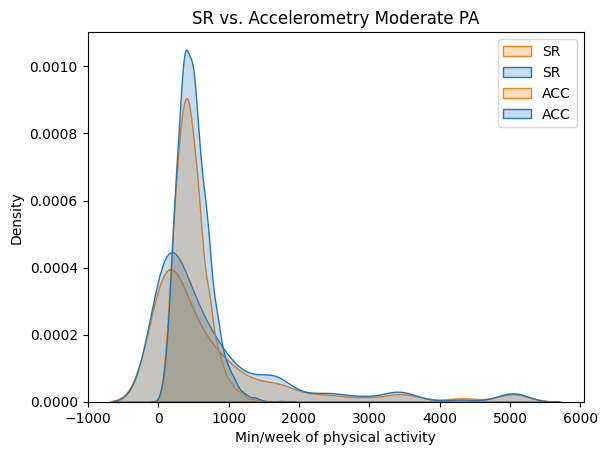

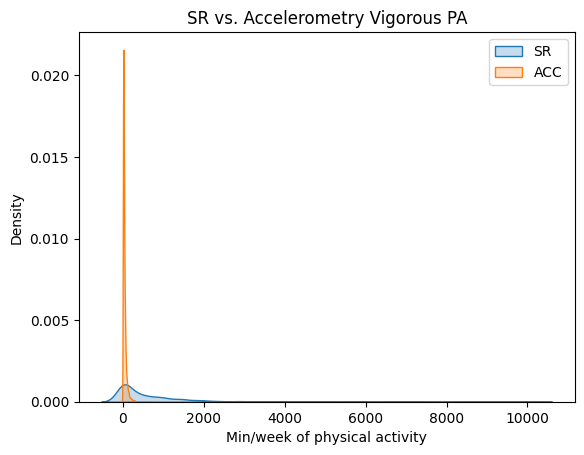

In [151]:
plt.figure()
sns.kdeplot(data = main_test, x= 'LPA', fill=True, label = "Light PA")
sns.kdeplot(data = main_test, x= 'MPA', fill=True, label = "Moderate PA")
sns.kdeplot(data = main_test, x= 'VPA', fill=True, label = "Vigorous PA")
sns.kdeplot(data = main_test, x= 'TPA', fill=True, label = "Total PA")
plt.xlabel("Min/week of physical activity")
plt.legend()
plt.ylim(0,0.01)
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRLPA', fill=True, label = "Light PA")
sns.kdeplot(data = main_test, x= 'SRMPA', fill=True, label = "Moderate PA")
sns.kdeplot(data = main_test, x= 'SRVPA', fill=True, label = "Vigorous PA")
plt.xlabel("Min/week of physical activity")
plt.title("Self Report PA distributions")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRLPA', fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'LPA', fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Light PA")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRMPA', fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'MPA', fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Moderate PA")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRMPA', hue = "Gender", fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'MPA', hue = "Gender", fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Moderate PA")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRVPA', fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'VPA', fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Vigorous PA")
plt.legend()
plt.show()

## 3.4 Health and Fitness

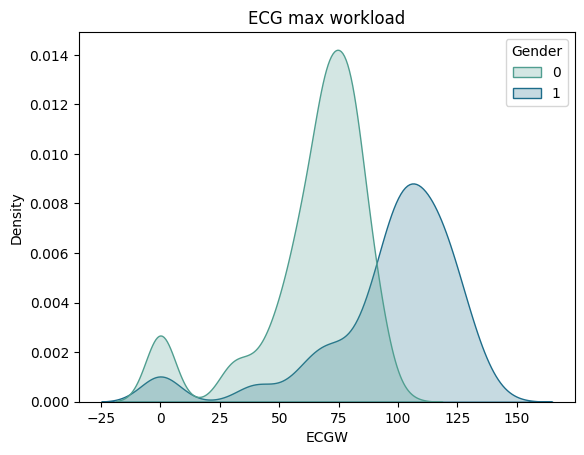

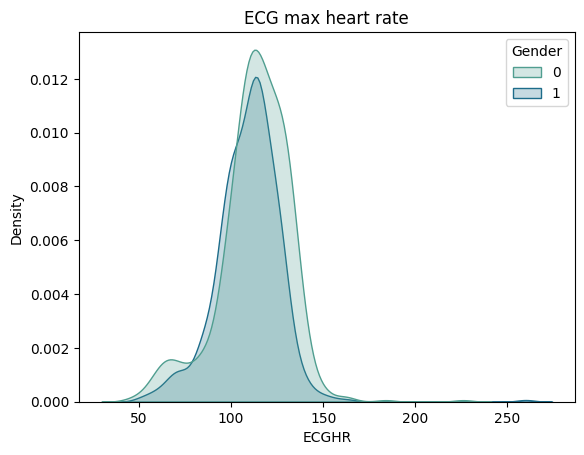

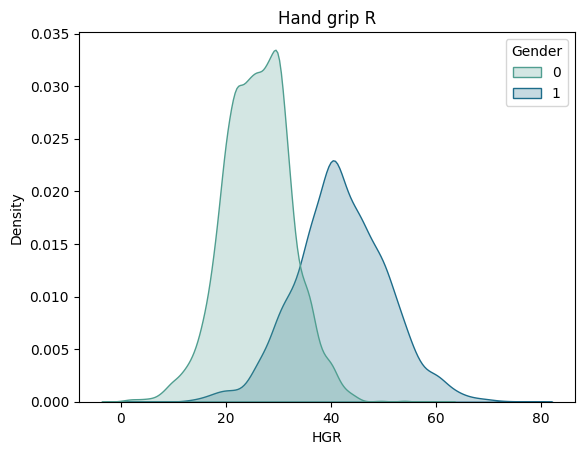

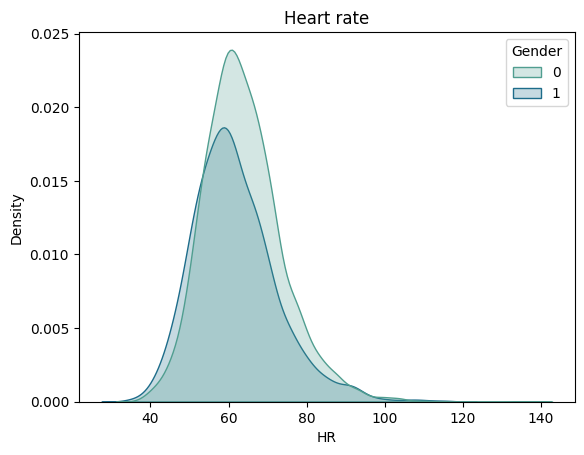

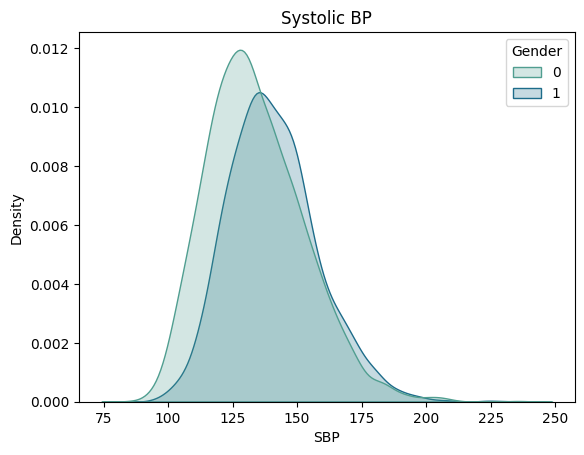

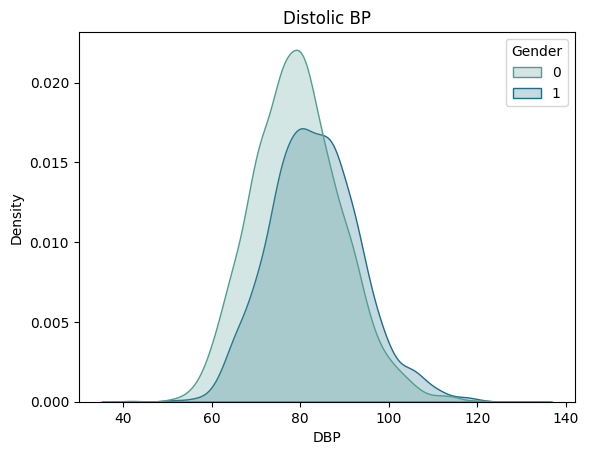

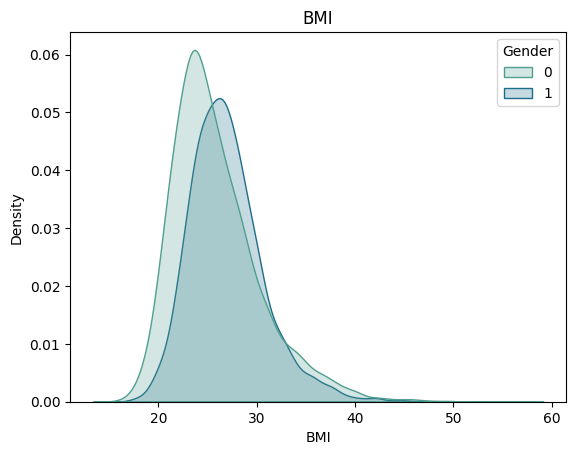

In [152]:
plt.figure()
sns.kdeplot(data = main_test, x= 'ECGW', hue = 'Gender', fill=True, palette = "crest")
plt.title("ECG max workload")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'ECGHR', hue = 'Gender', fill=True, palette = "crest")
plt.title("ECG max heart rate")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'HGR', hue = 'Gender', fill=True, palette = "crest")
plt.title("Hand grip R")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'HR', hue = 'Gender', fill=True, palette = "crest")
plt.title("Heart rate")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SBP', hue = 'Gender', fill=True, palette = "crest")
plt.title("Systolic BP")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'DBP', hue = 'Gender', fill=True, palette = "crest")
plt.title("Distolic BP")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'BMI', hue = 'Gender', fill=True, palette = "crest")
plt.title("BMI")
plt.show()

In [153]:
main_test = stats.zscore(main_test,nan_policy='omit')

# 4 Simple Correlation Heatmap

Text(0.5, 1.0, 'Correlations All')

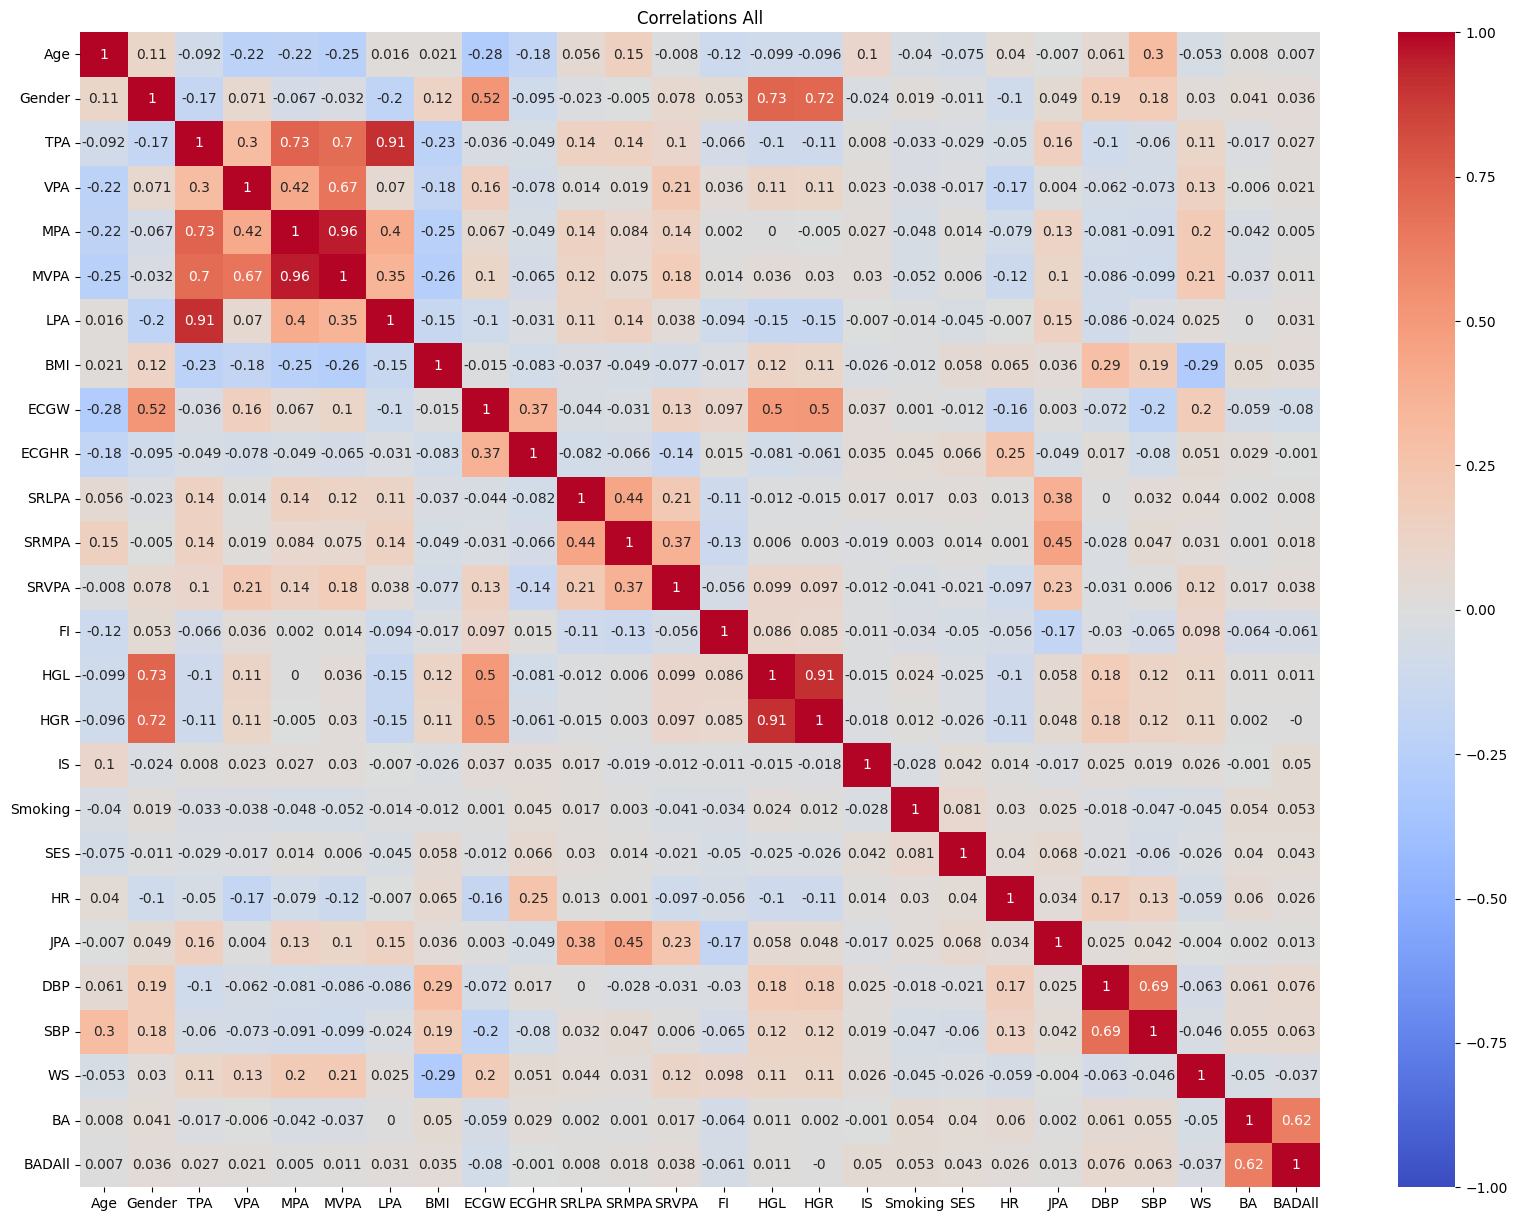

In [154]:
corr = main_test.corr()
corr = round(corr,3)
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, annot=True, cmap = "coolwarm", vmin=-1, vmax=1)
plt.title("Correlations All")

# 5 Partial Correlations with Covariates

In [155]:
cov_correlation = pg.partial_corr(data=main_test, x='SRLPA', y='BA', covar=["Gender", "IS", "Age"])
print("SR Light PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='SRMPA', y='BA', covar=["Gender", "IS", "Age"])
print("SR Moderate PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='SRVPA', y='BA', covar=["Gender", "IS", "Age"])
print("SR Vigorous PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='TPA', y='BA', covar=["Gender", "IS", "Age"])
print("Total PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='LPA', y='BA', covar=["Gender", "IS", "Age"])
print("Light PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='MPA', y='BA', covar=["Gender", "IS", "Age"])
print("Moderate PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='VPA', y='BA', covar=["Gender", "IS", "Age"])
print("Vigorous PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='MVPA', y='BA', covar=["Gender", "IS", "Age"])
print("Moderate+Vigorous PA")
print(cov_correlation)

SR Light PA
            n         r          CI95%    p-val
pearson  6407  0.003316  [-0.02, 0.03]  0.79076
SR Moderate PA
            n         r          CI95%     p-val
pearson  6407  0.001764  [-0.02, 0.03]  0.887762
SR Vigorous PA
            n         r          CI95%     p-val
pearson  6407  0.013724  [-0.01, 0.04]  0.272156
Total PA
            n         r          CI95%     p-val
pearson  7509 -0.010196  [-0.03, 0.01]  0.377093
Light PA
            n         r          CI95%     p-val
pearson  7509  0.008545  [-0.01, 0.03]  0.459172
Moderate PA
            n         r           CI95%     p-val
pearson  7509 -0.040022  [-0.06, -0.02]  0.000524
Vigorous PA
            n         r          CI95%     p-val
pearson  7509 -0.008583  [-0.03, 0.01]  0.457159
Moderate+Vigorous PA
            n         r           CI95%     p-val
pearson  7509 -0.035811  [-0.06, -0.01]  0.001915


# 6 Models with OLS

## 6.1 Covariates

In [156]:
cov_model = ols('BA ~ Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(cov_model.summary())

#calculate effect size
results = cov_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.254
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           2.06e-05
Time:                        16:07:03   Log-Likelihood:                -10639.
No. Observations:                7509   AIC:                         2.129e+04
Df Residuals:                    7502   BIC:                         2.134e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0042      0.012     -0.363      0.7

## 6.2 Accelerometer PA

In [157]:
pa_model = ols('BA ~ LPA + MPA + VPA + Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(pa_model.summary())

#calculate effect size
results = pa_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.490
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           1.47e-07
Time:                        16:07:04   Log-Likelihood:                -10630.
No. Observations:                7509   AIC:                         2.128e+04
Df Residuals:                    7499   BIC:                         2.135e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0042      0.012     -0.362      0.7

## 6.3 Self-report PA

In [158]:
sr_model = ols('BA ~ SRLPA + SRMPA + SRVPA +Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(sr_model.summary())

#calculate effect size
results = sr_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.170
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           0.000792
Time:                        16:07:05   Log-Likelihood:                -9050.3
No. Observations:                6407   AIC:                         1.812e+04
Df Residuals:                    6397   BIC:                         1.819e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0011      0.013      0.087      0.9

## 6.4 SR + Job PA + FI

In [159]:
sr_ex_model = ols('BA ~ SRLPA + SRMPA + SRVPA + FI + JPA + Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(sr_ex_model.summary())

#calculate effect size
results = sr_ex_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.103
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           0.000363
Time:                        16:07:06   Log-Likelihood:                -4196.9
No. Observations:                3019   AIC:                             8418.
Df Residuals:                    3007   BIC:                             8490.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0401      0.020     -2.047      0.0

## 6.5 Accelerometer + Self-report PA

In [160]:
sr_pa_model = ols('BA ~ SRLPA + SRMPA + SRVPA +LPA + MPA + VPA+ Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(sr_pa_model.summary())

#calculate effect size
results = sr_pa_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.162
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           1.52e-06
Time:                        16:07:07   Log-Likelihood:                -9039.6
No. Observations:                6407   AIC:                         1.811e+04
Df Residuals:                    6394   BIC:                         1.819e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0022      0.013      0.172      0.8

## 6.6 PA + Fitness

In [161]:
pa_fitness = ols('BA ~ HGR + HGL + ECGW + LPA + MPA + VPA + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(pa_fitness.summary())

#calculate effect size
results = pa_fitness
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     3.762
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           1.23e-05
Time:                        16:07:10   Log-Likelihood:                -1839.0
No. Observations:                1309   AIC:                             3704.
Df Residuals:                    1296   BIC:                             3771.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0150      0.034     -0.446      0.6

## 6.7 Fitness

In [162]:
fitness = ols('BA ~ HGR + HGL + ECGW + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(fitness.summary())

#calculate effect size
results = fitness
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     4.208
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           2.20e-05
Time:                        16:07:13   Log-Likelihood:                -1842.6
No. Observations:                1309   AIC:                             3705.
Df Residuals:                    1299   BIC:                             3757.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0152      0.034     -0.453      0.6

## 6.8 Health

In [163]:
health = ols('BA ~ ECGHR + SBP + HR + DBP + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(health.summary())

#calculate effect size
results = health
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.121
Date:                Fri, 06 Jan 2023   Prob (F-statistic):              0.342
Time:                        16:07:17   Log-Likelihood:                -1534.1
No. Observations:                1089   AIC:                             3090.
Df Residuals:                    1078   BIC:                             3145.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0139      0.039     -0.358      0.7

## 6.9 Health and Fitness

In [164]:
he_fi = ols('BA ~ HGR + SBP + HR + DBP + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(he_fi.summary())

#calculate effect size
results = he_fi
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     9.617
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           4.40e-16
Time:                        16:07:21   Log-Likelihood:                -8329.1
No. Observations:                5925   AIC:                         1.668e+04
Df Residuals:                    5914   BIC:                         1.675e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0082      0.013     -0.634      0.5

## 6.10 Fluid intelligence

In [165]:
fi = ols('BA ~ FI + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(fi.summary())

#calculate effect size
results = fi
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     7.107
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           1.78e-08
Time:                        16:07:27   Log-Likelihood:                -7511.7
No. Observations:                5308   AIC:                         1.504e+04
Df Residuals:                    5300   BIC:                         1.509e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0204      0.014     -1.473      0.1

## 6.11 Fitness models

In [166]:
fit = ols('HGR ~ LPA + MPA + VPA + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(fit.summary())

#calculate effect size
results = fit
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                    HGR   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     1033.
Date:                Fri, 06 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:07:30   Log-Likelihood:                -7593.8
No. Observations:                7483   AIC:                         1.521e+04
Df Residuals:                    7473   BIC:                         1.528e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0009      0.008      0.111      0.9

In [167]:
fit2 = ols('HGR ~ LPA + MPA + VPA + SRLPA + SRMPA + SRVPA + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(fit2.summary())

#calculate effect size
results = fit2
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                    HGR   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     660.1
Date:                Fri, 06 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:07:33   Log-Likelihood:                -6489.4
No. Observations:                6385   AIC:                         1.300e+04
Df Residuals:                    6372   BIC:                         1.309e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0017      0.008      0.195      0.8

# 7 Model comparisons

## 7.1 Cov x PA

In [168]:
model_comparison = anova_lm(cov_model, pa_model)
print(model_comparison)

   df_resid          ssr  df_diff    ss_diff         F    Pr(>F)
0    7502.0  7477.577239      0.0        NaN       NaN       NaN
1    7499.0  7459.844730      3.0  17.732509  5.941861  0.000482


In [169]:
model_comparison = anova_lm(cov_model, sr_model)
print(model_comparison)

   df_resid          ssr  df_diff      ss_diff         F    Pr(>F)
0    7502.0  7477.577239      0.0          NaN       NaN       NaN
1    6397.0  6325.870590   1105.0  1151.706649  1.053988  0.123213


## 7.2 Cov x PA x SR

In [170]:
model_comparison = anova_lm(sr_model, sr_pa_model)
print(model_comparison)

   df_resid          ssr  df_diff    ss_diff         F    Pr(>F)
0    6397.0  6325.870590      0.0        NaN       NaN       NaN
1    6394.0  6304.836153      3.0  21.034437  7.110636  0.000091


In [171]:
model_comparison = anova_lm(pa_model, sr_pa_model)
print(model_comparison)

   df_resid          ssr  df_diff      ss_diff         F    Pr(>F)
0    7499.0  7459.844730      0.0          NaN       NaN       NaN
1    6394.0  6304.836153   1105.0  1155.008577  1.060039  0.099415


## 7.3 SR x Job + FI

In [172]:
model_comparison = anova_lm(sr_model, sr_ex_model)
print(model_comparison)

   df_resid          ssr  df_diff      ss_diff         F    Pr(>F)
0    6397.0  6325.870590      0.0          NaN       NaN       NaN
1    3007.0  2850.191309   3390.0  3475.679281  1.081682  0.013435


## 7.4 Fitness models

In [173]:
model_comparison = anova_lm(fit, fit2)
print(model_comparison)

   df_resid          ssr  df_diff     ss_diff         F    Pr(>F)
0    7473.0  3334.662671      0.0         NaN       NaN       NaN
1    6372.0  2854.128509   1101.0  480.534163  0.974404  0.708548


# 8 Mediation analysis

## 8.1 PA x Health / Fitness

### 8.1.1 BMI

In [174]:
#regression of x on m
model1 = ols('BMI ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ BMI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['BMI']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.012327432937216236
Direct effect: -0.030097234903312148
Total effect: -0.04242466784052838


### 8.1.2 DBP

In [175]:
#regression of x on m
model1 = ols('DBP ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ DBP',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['DBP']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.00491393830135637
Direct effect: -0.03751072953917201
Total effect: -0.04242466784052838


### 8.1.3 Heart rate

In [176]:
#regression of x on m
model1 = ols('HR ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ HR',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['HR']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.004719727566260298
Direct effect: -0.03770494027426809
Total effect: -0.04242466784052838


### 8.1.4 Hand grip

In [177]:
#regression of x on m
model1 = ols('HGR ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ HGR',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['HGR']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -1.0528843190560369e-05
Direct effect: -0.04241413899733782
Total effect: -0.04242466784052838


## 8.2 SR PA x Job PA / Fluid intelligence

In [178]:
#regression of x on m
model1 = ols('FI ~ SRMPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ SRMPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['SRMPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['SRMPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 0.00864788999072817
Direct effect: -0.00771712972545638
Total effect: 0.0009307602652717901


In [179]:
#regression of x on m
model1 = ols('FI ~ SRMPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ SRMPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['SRMPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['SRMPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 0.00864788999072817
Direct effect: -0.00771712972545638
Total effect: 0.0009307602652717901


In [180]:
#regression of x on m
model1 = ols('FI ~ JPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ JPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['JPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['JPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 0.011855062860981097
Direct effect: -0.009504604278126452
Total effect: 0.002350458582854644


# 9 LASSO Regression

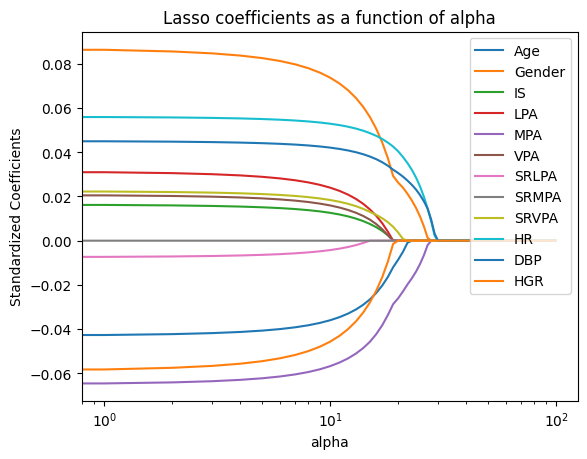

In [181]:
df = main_test[["Age", "Gender", "IS", "LPA", "MPA", "VPA",  "SRLPA", "SRMPA", "SRVPA", "HR", "DBP", "HGR", "BA"]]
df = df.dropna()
df = pd.DataFrame(df)
X = df[["Age", "Gender", "IS", "LPA", "MPA", "VPA",  "SRLPA", "SRMPA", "SRVPA", "HR", "DBP", "HGR"]]
Y = df["BA"]
columns = ["Age", "Gender", "IS", "LPA", "MPA", "VPA",  "SRLPA", "SRMPA", "SRVPA", "HR", "DBP", "HGR"]

coefs = []
alphas = np.power(10,np.linspace(start=-3, stop=3, num=100))

for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X,Y)
    coefs.append(lasso.coef_)

coefs = pd.DataFrame(coefs)
coefs.columns = columns
coefs = pd.DataFrame(coefs)

plt.plot(coefs)
plt.xticks(alphas)
plt.xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha')
plt.legend(columns, loc="upper right")

# 10 Pickle for comparison to exploration set

In [182]:
main_test.to_pickle("6_main_test.pkl")